# Logistic Regression :
***Problem Statement :***
- Output variable = y
- y = Whether the client has subscribed a term deposit or not 
- Binomial ("yes" or "no")


In [33]:
# Importing usefull libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sys
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn import metrics

# Ignore annoying warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing the dataset
df = pd.read_csv("bank-full.csv", sep=';')

# Showing first 5 rows from dataset
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
# Total rows & columns in dataset
df.shape

(45211, 17)

In [4]:
# Information about dataset
# Find missing values of each feature in the data set.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
# Checking null values present in dataset
df.isnull().any().any()

False

In [6]:
# Checking additional stats from dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


In [7]:
# Showing in integer format
df.describe().astype(np.int64).T

,count,mean,std,min,25%,50%,75%,max
age,45211,40,10,18,33,39,48,95
balance,45211,1362,3044,-8019,72,448,1428,102127
day,45211,15,8,1,8,16,21,31
duration,45211,258,257,0,103,180,319,4918
campaign,45211,2,3,1,1,2,3,63
pdays,45211,40,100,-1,-1,-1,-1,871
previous,45211,0,2,0,0,0,0,275


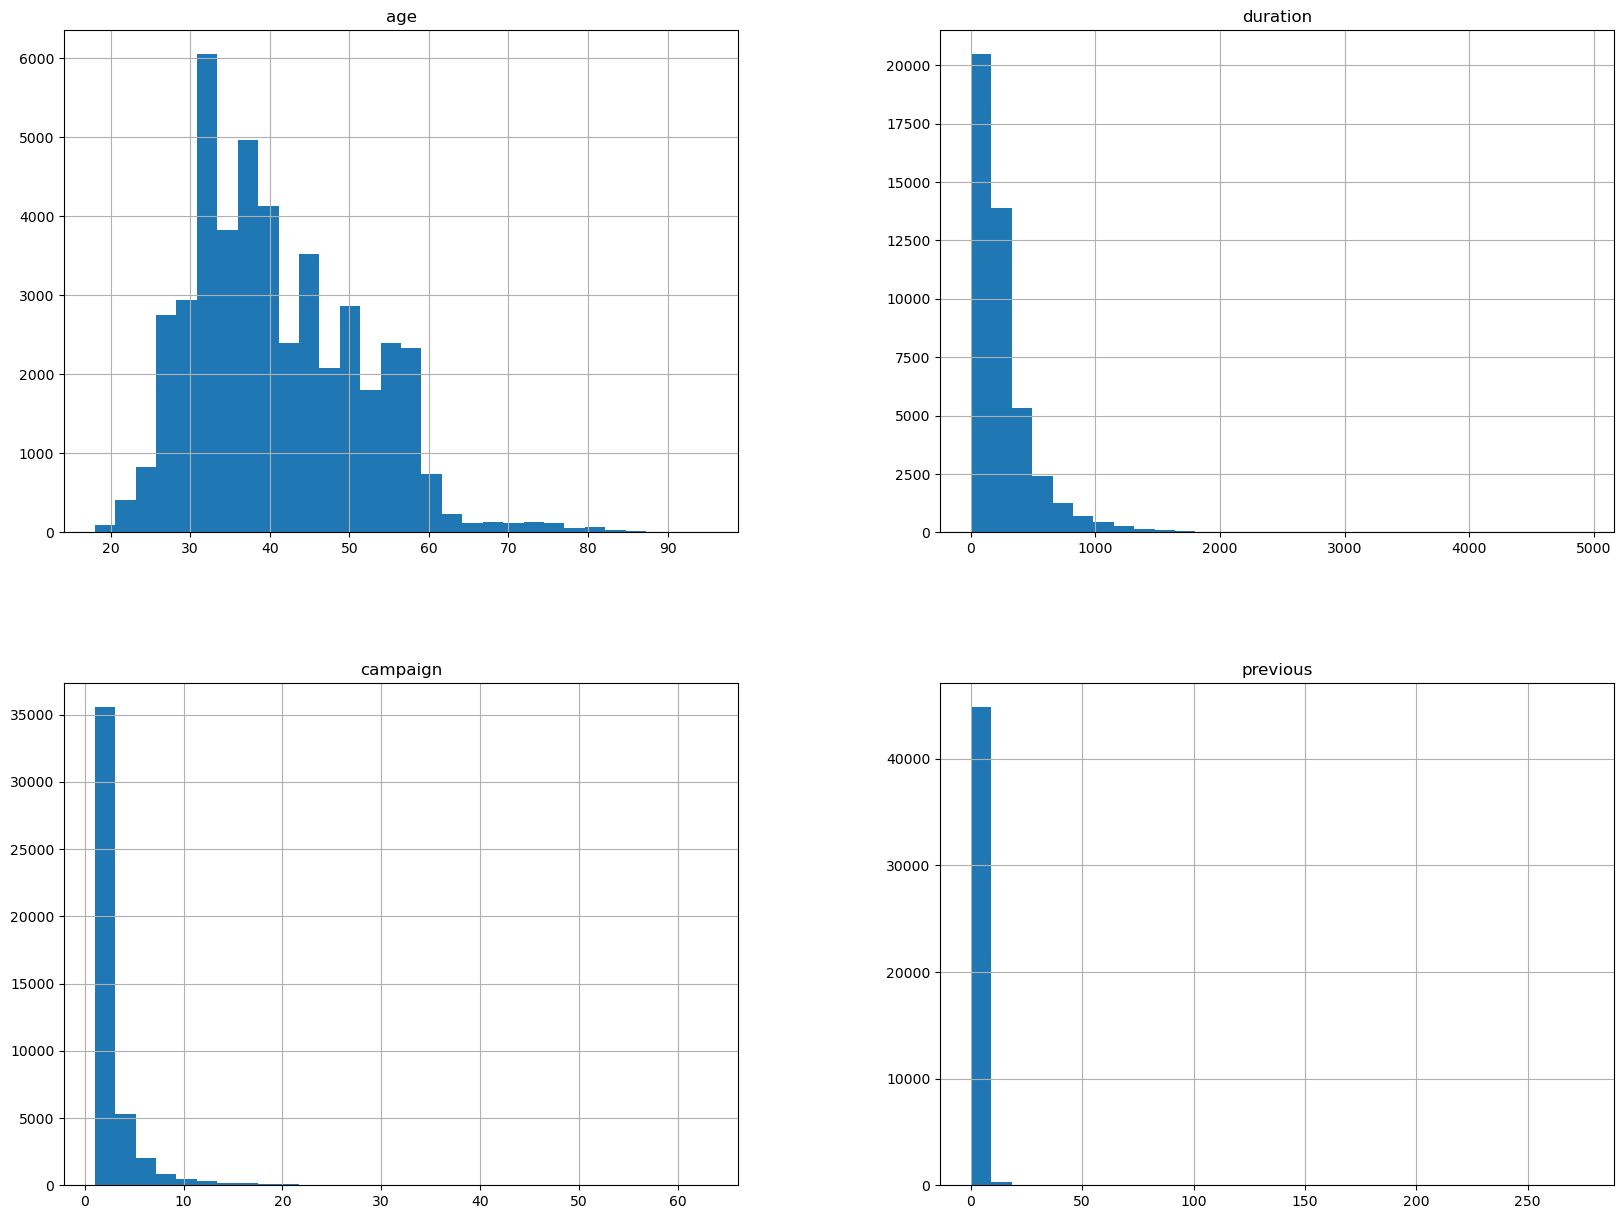

In [8]:
# To get a feel for the type of data we are dealing with.
# We visualize distributions of numerical features with histograms
df[['age','duration','campaign','previous']].hist(bins=30, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

In [9]:
# Correlation between numerical columns
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(4)

,age,balance,day,duration,campaign,pdays,previous
age,1.0000,0.0978,-0.0091,-0.0046,0.0048,-0.0238,0.0013
balance,0.0978,1.0000,0.0045,0.0216,-0.0146,0.0034,0.0167
day,-0.0091,0.0045,1.0000,-0.0302,0.1625,-0.0930,-0.0517
duration,-0.0046,0.0216,-0.0302,1.0000,-0.0846,-0.0016,0.0012
campaign,0.0048,-0.0146,0.1625,-0.0846,1.0000,-0.0886,-0.0329
pdays,-0.0238,0.0034,-0.0930,-0.0016,-0.0886,1.0000,0.4548
previous,0.0013,0.0167,-0.0517,0.0012,-0.0329,0.4548,1.0000


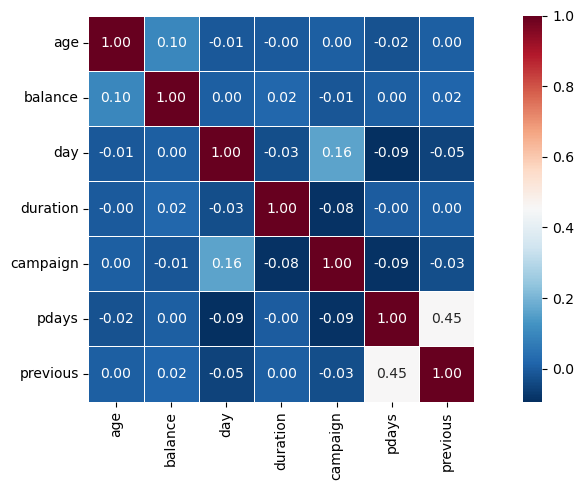

In [10]:
# Visualize feature correlations
fig, ax = plt.subplots(figsize=(10,5))  
sns.heatmap(df._get_numeric_data().astype(float).corr(),
            square=True, cmap='RdBu_r', linewidths=.5,
            annot=True, fmt='.2f').figure.tight_layout()
plt.show()

In [11]:
# Checking unique values from each column
category_features = df.select_dtypes(include=['object', 'bool']).columns.values

for col in category_features:
    print(col, "(", len(df[col].unique()) , "values):\n", np.sort(df[col].unique()))

job ( 12 values):
 ['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed' 'unknown']
marital ( 3 values):
 ['divorced' 'married' 'single']
education ( 4 values):
 ['primary' 'secondary' 'tertiary' 'unknown']
default ( 2 values):
 ['no' 'yes']
housing ( 2 values):
 ['no' 'yes']
loan ( 2 values):
 ['no' 'yes']
contact ( 3 values):
 ['cellular' 'telephone' 'unknown']
month ( 12 values):
 ['apr' 'aug' 'dec' 'feb' 'jan' 'jul' 'jun' 'mar' 'may' 'nov' 'oct' 'sep']
poutcome ( 4 values):
 ['failure' 'other' 'success' 'unknown']
y ( 2 values):
 ['no' 'yes']


In [12]:
for col in category_features:
    print(f"\033[1m\033[94m{col} \n{20 * '-'}\033[0m")    
    print(df[col].value_counts(), "\n")
    
print(df.nunique(axis=1))

job 
--------------------
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64 

marital 
--------------------
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64 

education 
--------------------
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64 

default 
--------------------
no     44396
yes      815
Name: default, dtype: int64 

housing 
--------------------
yes    25130
no     20081
Name: housing, dtype: int64 

loan 
--------------------
no     37967
yes     7244
Name: loan, dtype: int64 

contact 
--------------------
cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64 

month 
--------------------
may    13766
jul     6895
aug    

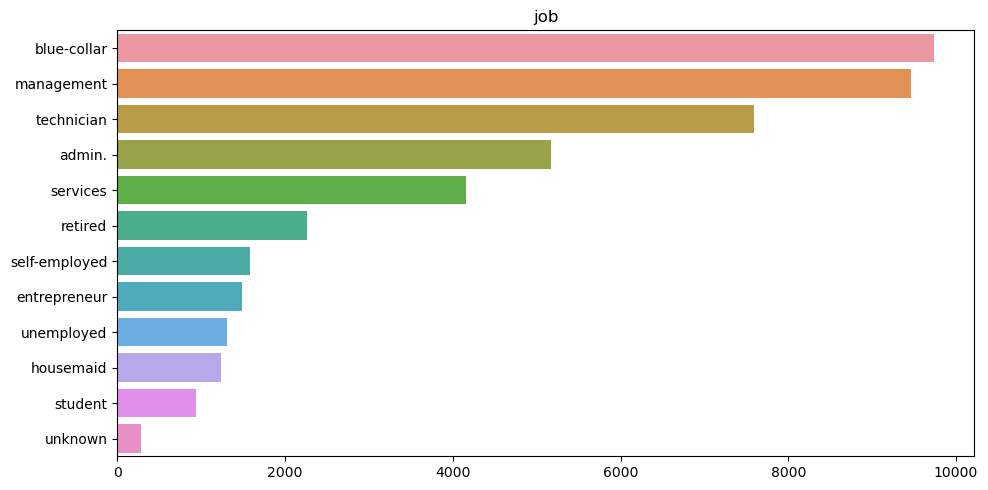

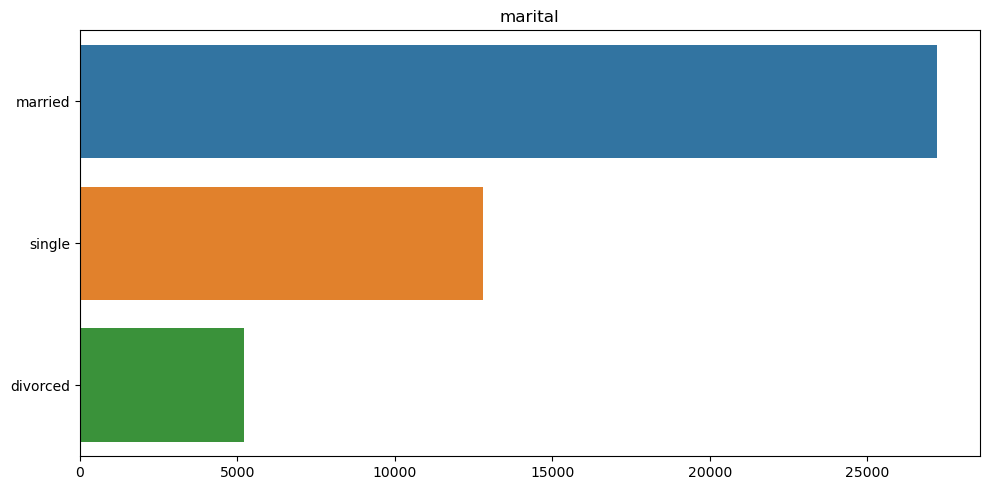

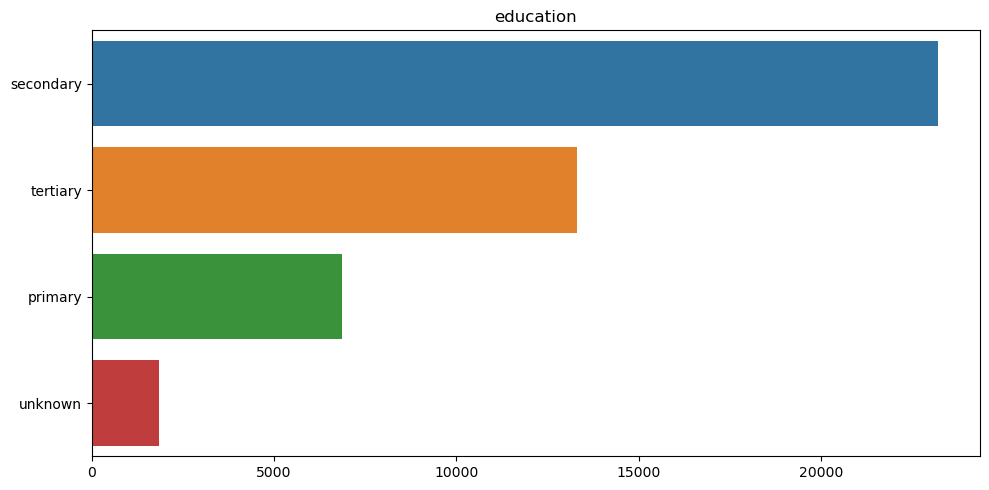

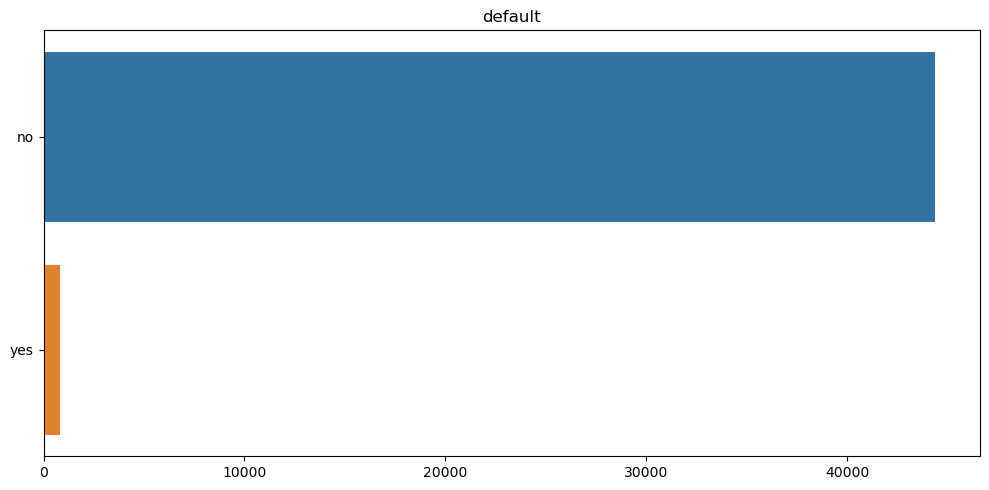

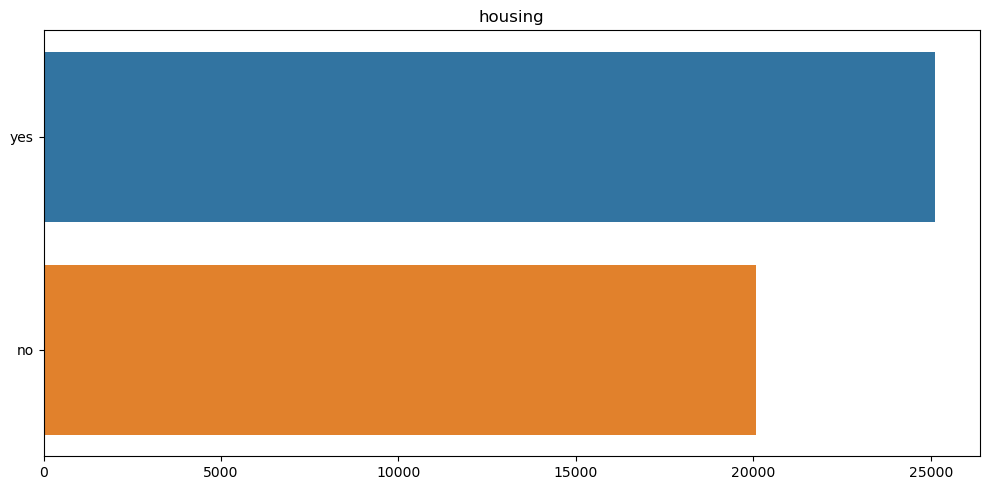

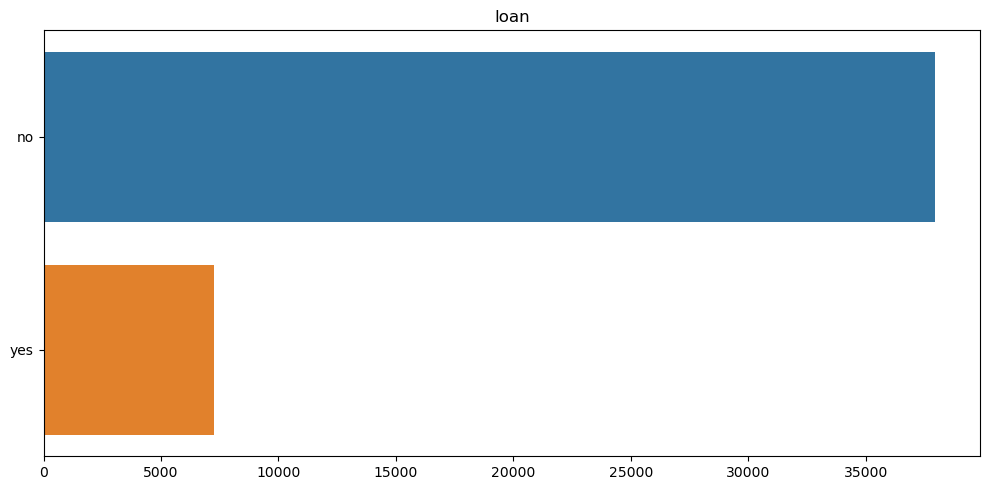

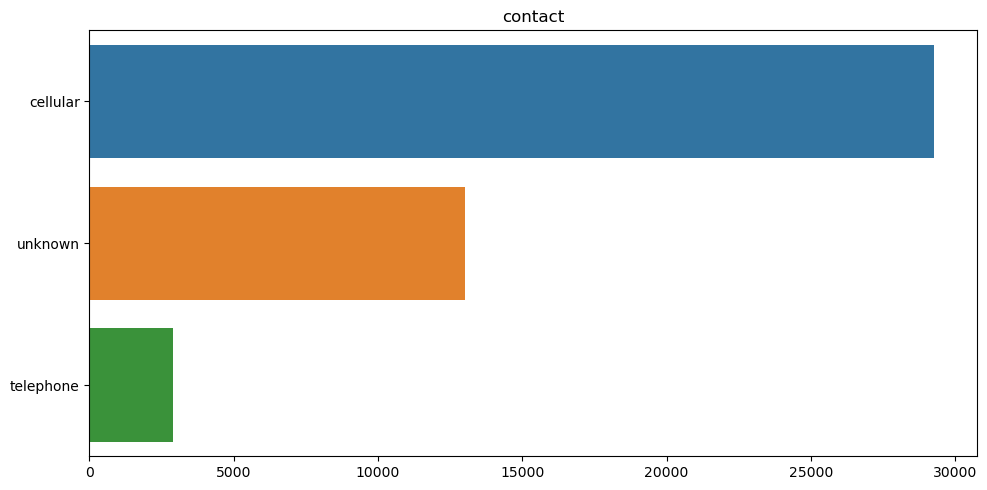

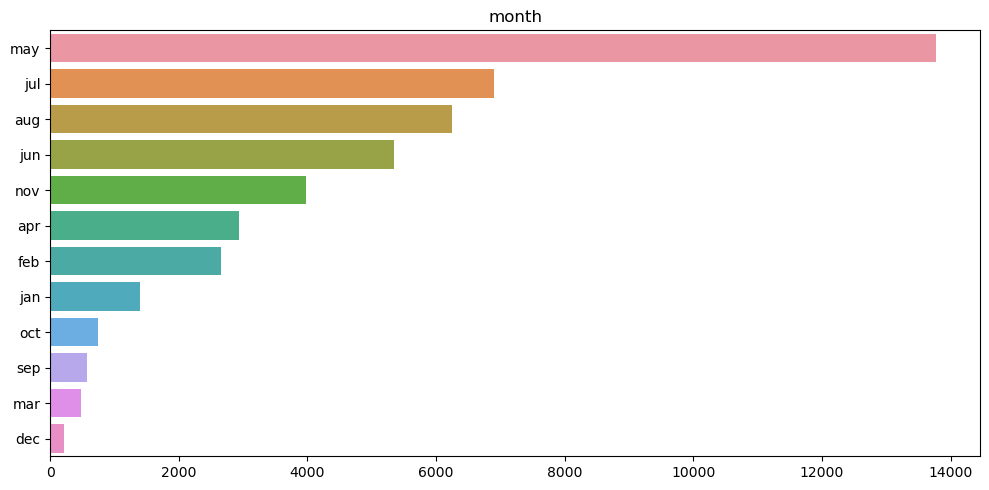

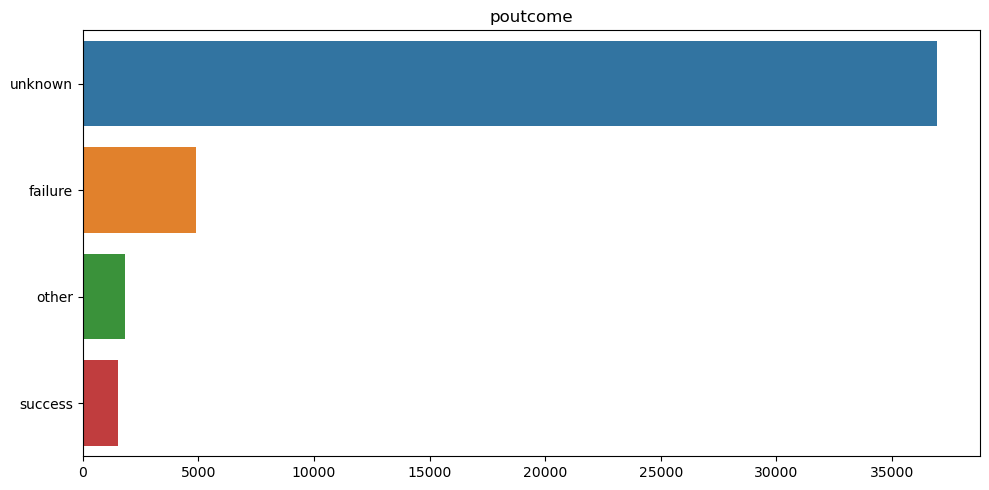

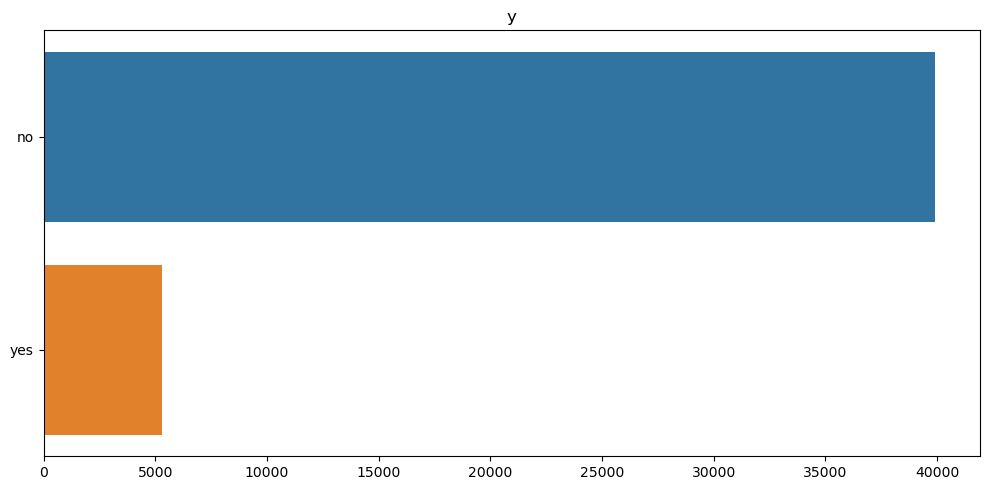

In [13]:
# Category data visualization
for col in category_features:
    plt.figure(figsize=(10,5))    
    sns.barplot(x=df[col].value_counts().values, y=df[col].value_counts().index, data=df)    
    plt.title(col)    
    plt.tight_layout()

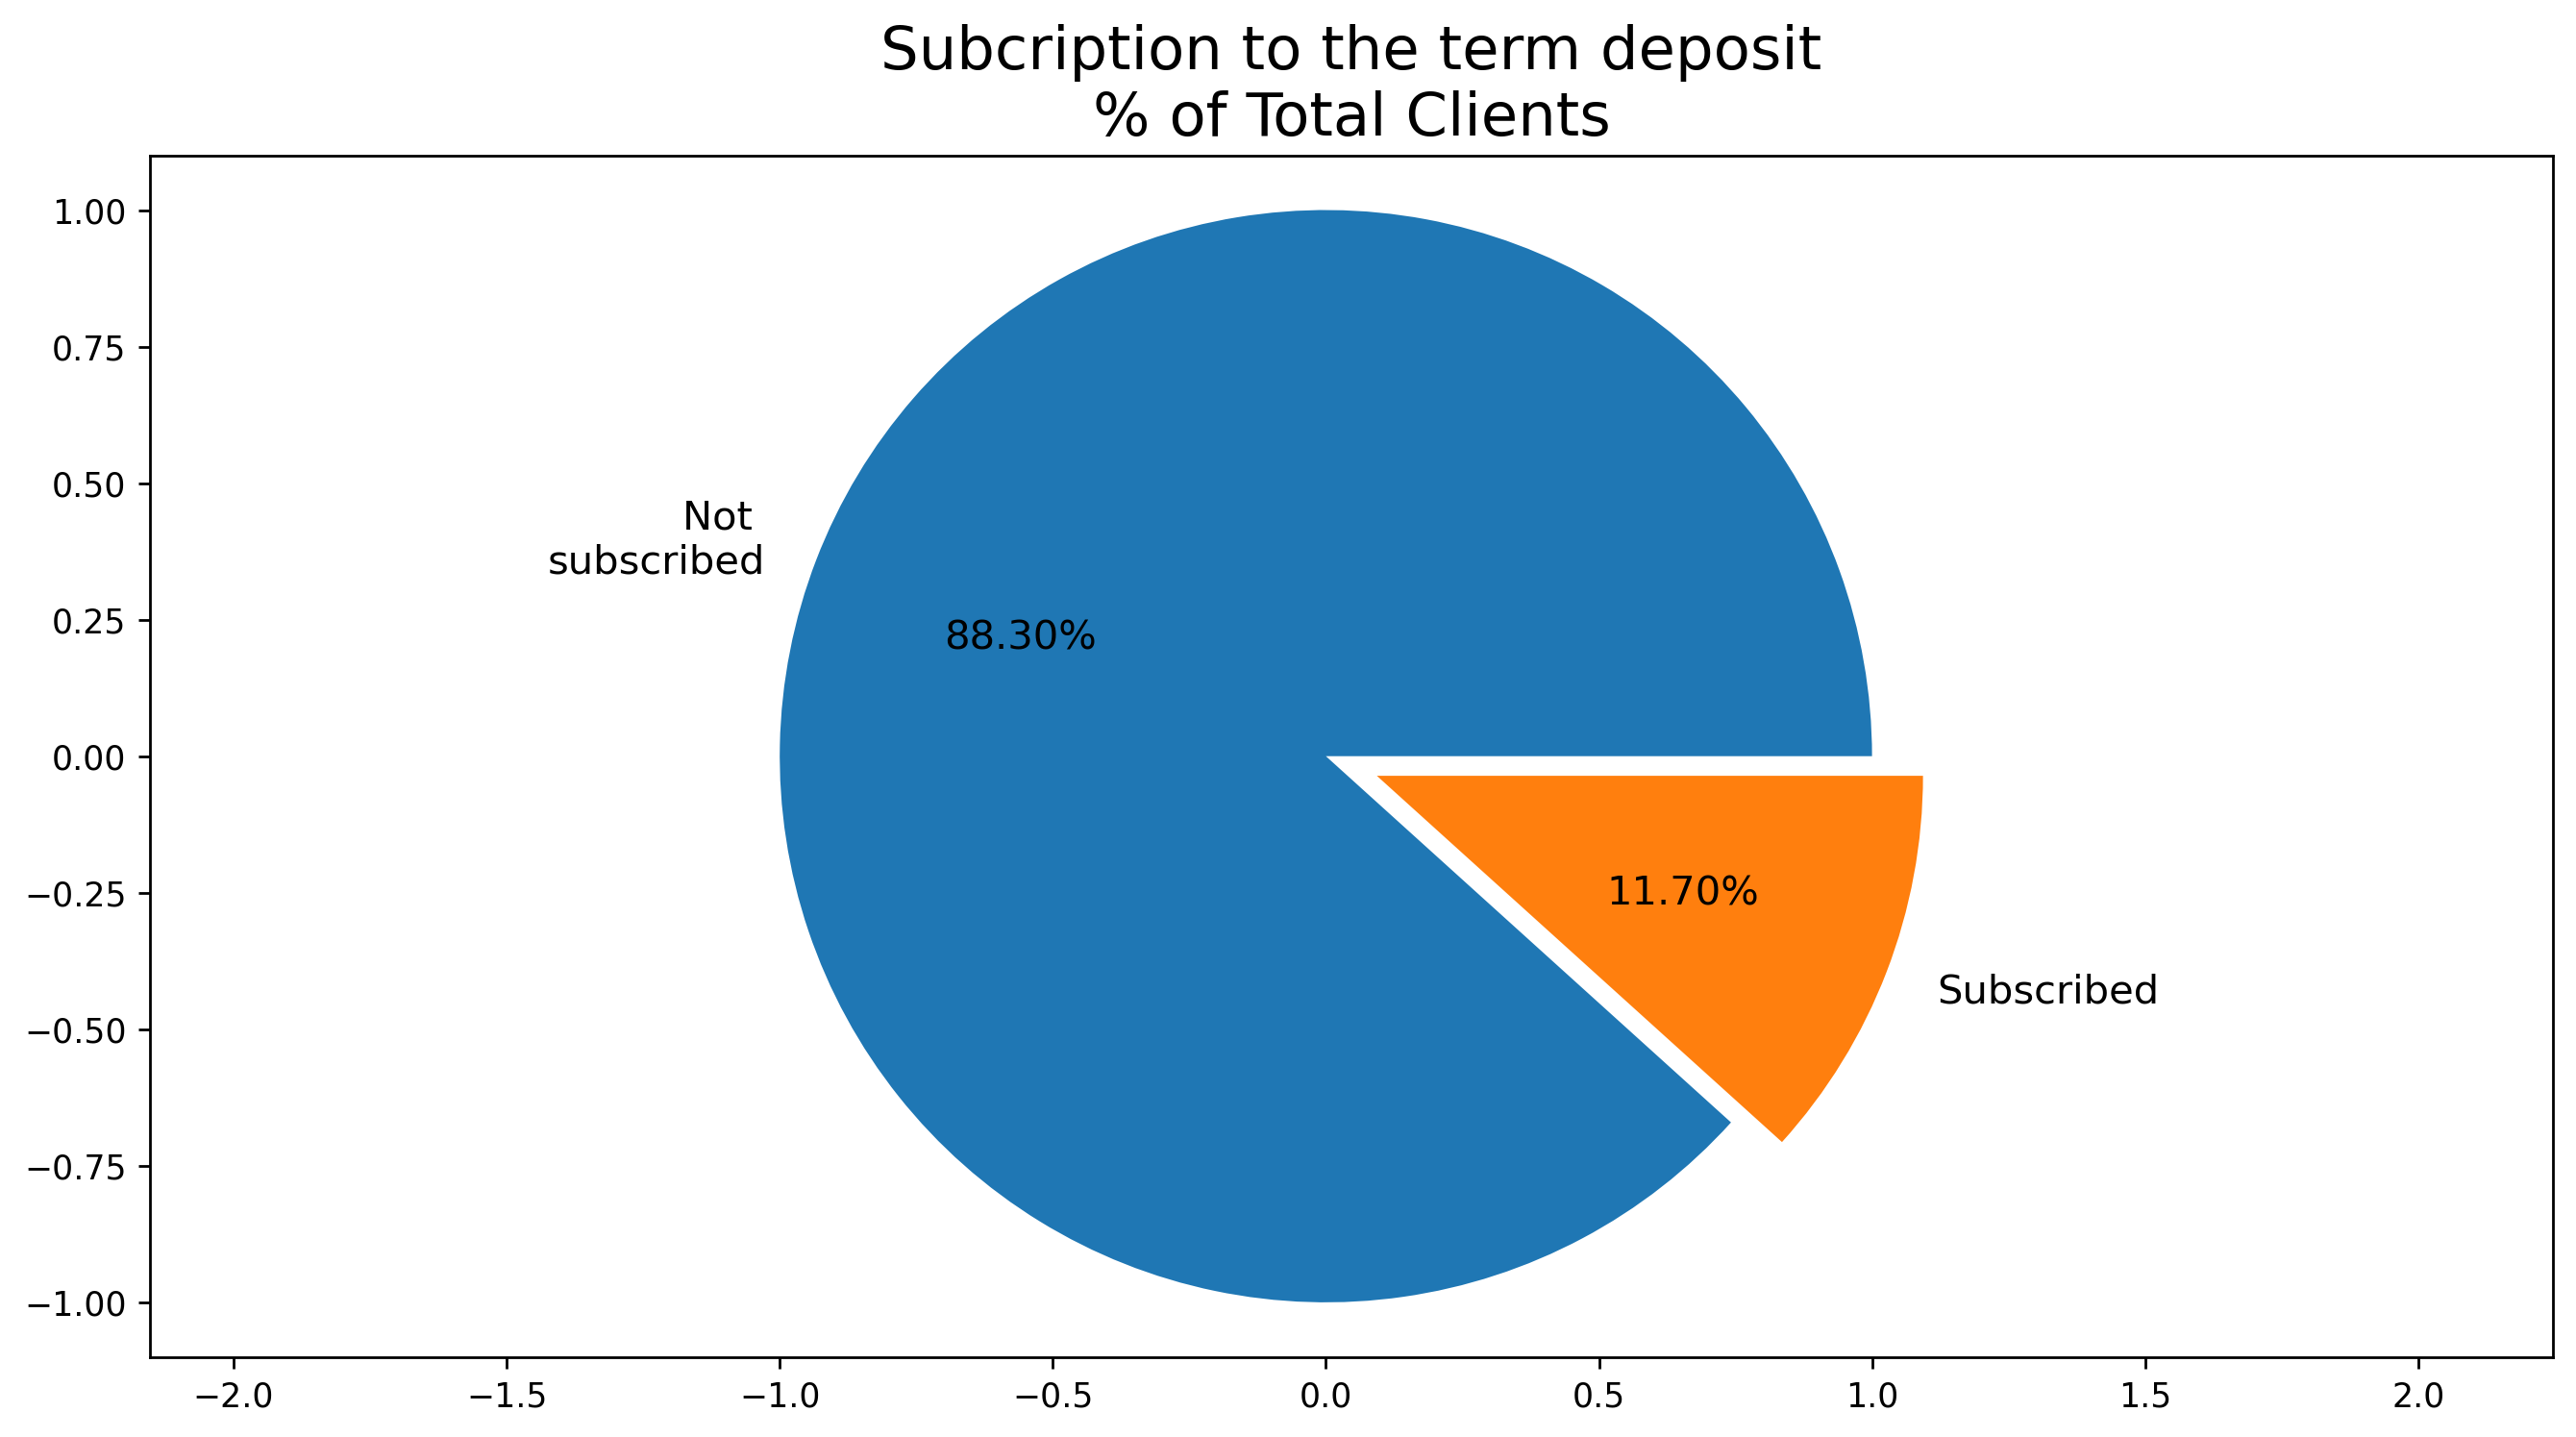

In [14]:
plt.rcParams['figure.figsize']=(10,5)
plt.rcParams['figure.dpi'] = 250

# Pie chart
labels = ["Not \nsubscribed", "Subscribed"]
explode = (0, 0.1)  # only "explode" the second slice (i.e. 'Subscribed')

# depicting the visualization 
fig = plt.figure() 
ax = fig.add_axes([0,0,1,1]) 

ax.pie(df['y'].value_counts(), 
       labels = labels,
       explode = explode,
       autopct ='%1.2f%%',
       frame = True,
       textprops = dict(color ="black", size=12)) 

ax.axis('equal') 
plt.title('Subcription to the term deposit\n% of Total Clients',
     loc='center',
     color = 'black', 
     fontsize = '18')

plt.show()

- 11.70% customers subscribed to the term deposit. Our classes are imbalanced where positive values (subscribed) are only 11.70%. In the next section, we will balance the classes.

In [15]:
# Top 5 of highly successful campaigns
# We will groupby then count
df.groupby(['campaign'])['y'].count().reset_index().sort_values(by='y', ascending=False).iloc[:5]

,campaign,y
0,1,17544
1,2,12505
2,3,5521
3,4,3522
4,5,1764


Text(0, 0.5, 'Frequency of Purchase')

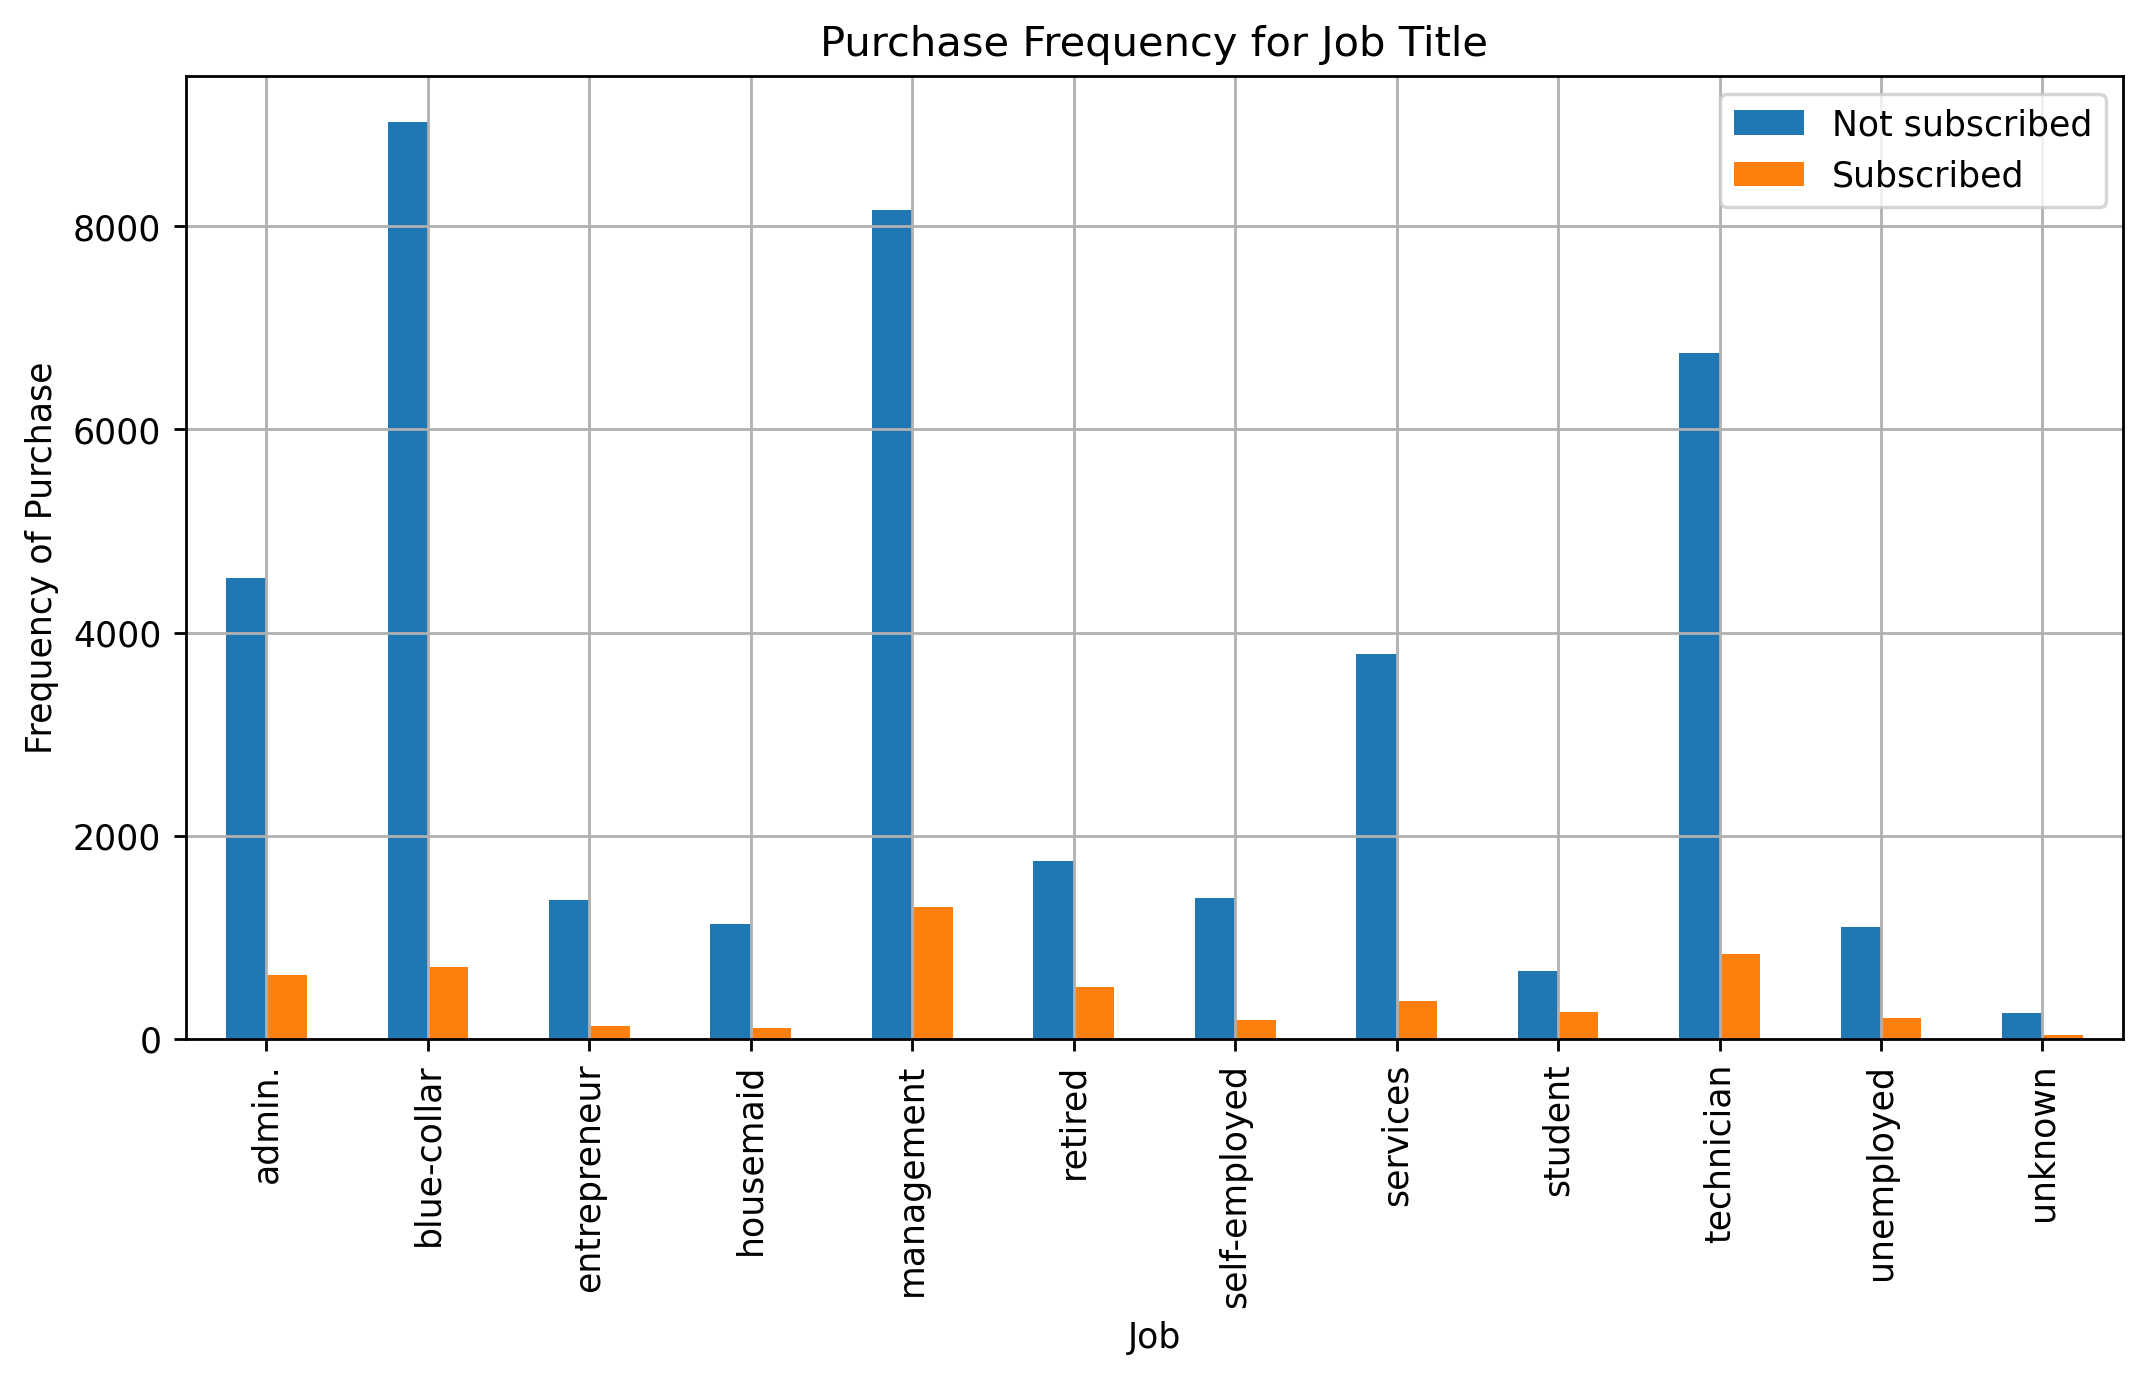

In [16]:
# Checking which customers are more likely to subscribe to the term deposit
plt.rcParams['figure.figsize']=(10,5)
plt.rcParams['figure.dpi'] = 250

table = pd.crosstab(df.job, df.y)
table.columns = ['Not subscribed', 'Subscribed']
table.plot(kind='bar')

plt.grid(True)

plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')

In [17]:
table = pd.crosstab(df.job, df.y)
table = round(table.div(table.sum(axis=1), axis=0).mul(100), 2)
table.columns=['notsubcribed', 'subcribed']
table.sort_values(by=['subcribed'], ascending=False).loc[:, 'subcribed']

job
student          28.68
retired          22.79
unemployed       15.50
management       13.76
admin.           12.20
self-employed    11.84
unknown          11.81
technician       11.06
services          8.88
housemaid         8.79
entrepreneur      8.27
blue-collar       7.27
Name: subcribed, dtype: float64

- Customers like admins, blue-collars and techinicians but the frequency of students and retired people subscribed to the term deposit are pretty high (28.68% for students and 22.79% for retired people).

Text(0, 0.5, 'Proportion of Customers')

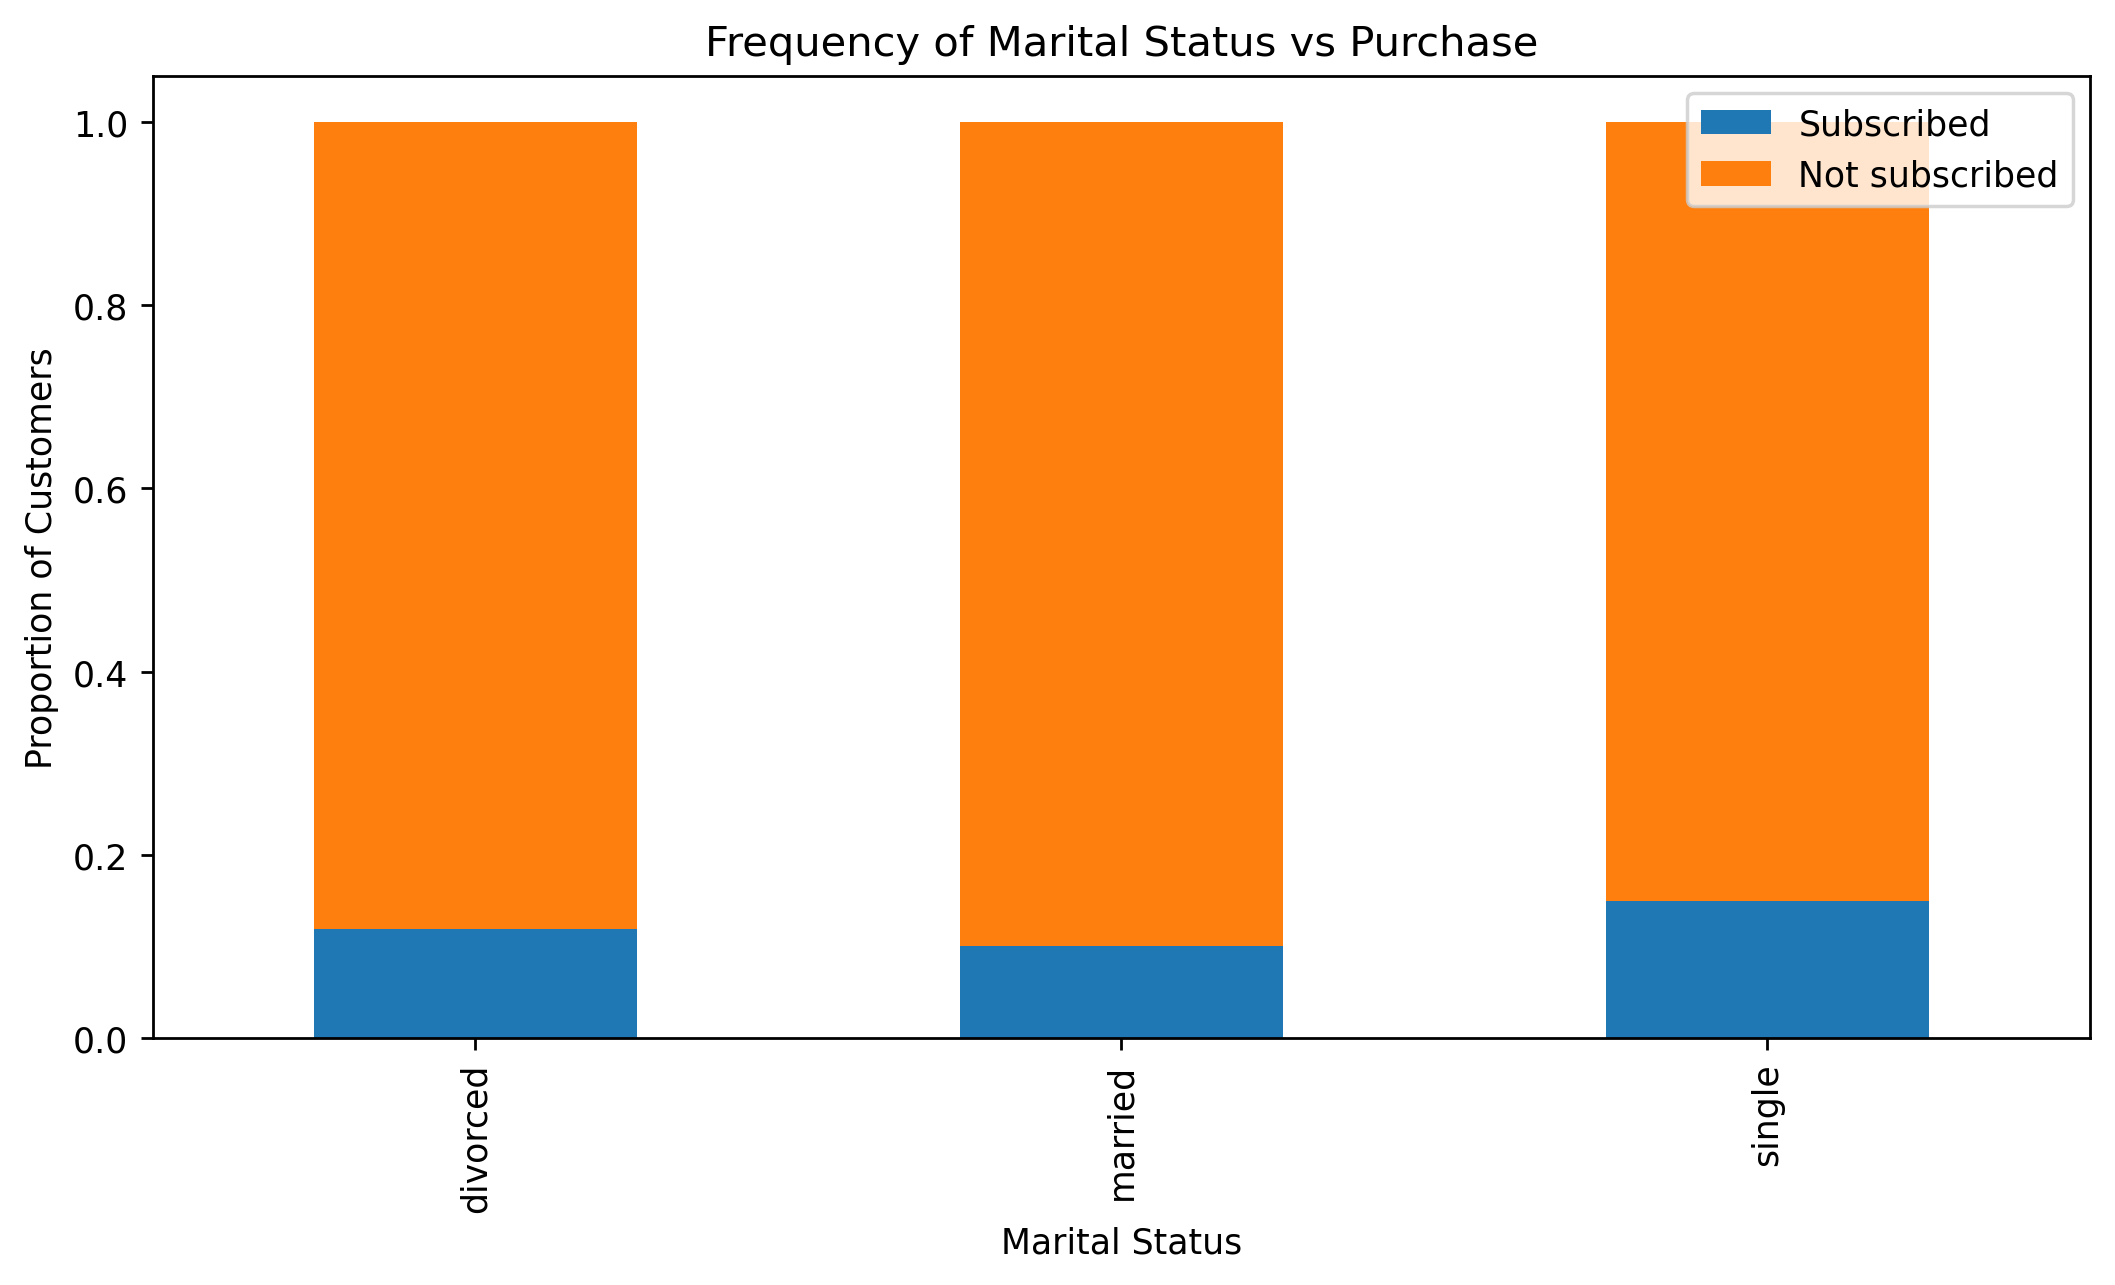

In [18]:
# Role of marital status in subscription behaviour
table = pd.crosstab(df.marital,df.y)
table = table.div(table.sum(1).astype(float), axis=0)
table.columns = ['Not subscribed', 'Subscribed']
# Ordering stacked bars and plot the chart
table[['Subscribed', 'Not subscribed']].plot(kind='bar', stacked=True)
plt.rcParams['figure.figsize']=(10,5)
plt.rcParams['figure.dpi'] = 250
plt.title('Frequency of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')

- There is no significant impact of marital status on subscription behaviour of customers.

In [19]:
# "duration" column highly affects the output target, this value is not known before a call is performed.
# Hence, this column should been discarded from the list of features to predict.

df = df.drop(['duration'], axis=1)

***Splitting dataset into train & test sets :***

In [20]:
# Creating independent & dependent variables
x = df.drop(columns=['y'])
y = df['y']

xtrain,xtest,ytrain,ytest = train_test_split(x, y, test_size=0.2, random_state=0)

print("Number transactions X_train dataset: ", xtrain.shape)
print("Number transactions y_train dataset: ", ytrain.shape)
print("Number transactions X_test dataset: ", xtest.shape)
print("Number transactions y_test dataset: ", ytest.shape)

Number transactions X_train dataset:  (36168, 15)
Number transactions y_train dataset:  (36168,)
Number transactions X_test dataset:  (9043, 15)
Number transactions y_test dataset:  (9043,)


***OneHotEncoding :***

In [21]:
# Using OneHotEncoding for converting ordinal and categorical variables to numerical values.

numeric_features = xtrain.select_dtypes(include=['float64', 'int64']).columns.values
numeric_features = numeric_features[numeric_features != 'y']

category_features = xtrain.select_dtypes(include=['object', 'bool']).columns.values

print("Numerical Columns :",numeric_features)
print("Categorical Columns :",category_features)

Numerical Columns : ['age' 'balance' 'day' 'campaign' 'pdays' 'previous']
Categorical Columns : ['job' 'marital' 'education' 'default' 'housing' 'loan' 'contact' 'month'
 'poutcome']


In [22]:
def dummify(ohe, x, columns):
    transformed_array = ohe.transform(x)

    # list of category columns
    enc = ohe.named_transformers_['cat'].named_steps['onehot']
    feature_lst = enc.get_feature_names(category_features.tolist())   
    
    cat_colnames = np.concatenate([feature_lst]).tolist()
    all_colnames = numeric_features.tolist() + cat_colnames 
    
    # convert numpy array to dataframe
    df = pd.DataFrame(transformed_array, index = x.index, columns = all_colnames)
    
    return transformed_array, df

In [23]:
# impute missing numerical values with a median value, then scale the values
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# impute missing categorical values using the 'missing' and one hot encode the categories
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Each transformer is a three-element tuple that defines the name of the transformer. 
# The transform to apply & the column features to apply it to
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, category_features)])

ohe = preprocessor.fit(xtrain)

xtrain_t = ohe.transform(xtrain)
xtest_t = ohe.transform(xtest)

In [24]:
# Transform training and testing set & then convert it to dataframe
xtrain_t_array, xtrain_t = dummify(ohe, xtrain, category_features)
xtest_t_array, xtest_t = dummify(ohe, xtest, category_features)

xtrain_t.head()

,age,balance,day,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
13932,1.515061,-0.231637,-0.698514,-0.567836,-0.410222,-0.241405,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9894,-0.369597,0.106038,-0.818717,-0.567836,-0.410222,-0.241405,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
39946,-0.558063,0.470635,-1.660136,0.402837,0.560728,0.585721,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9217,-0.558063,-0.375660,-1.299528,-0.567836,-0.410222,-0.241405,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4124,-0.275365,-0.340303,0.383311,-0.567836,-0.410222,-0.241405,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:
xtrain_columns = xtrain_t.columns
print(xtrain_columns)

Index(['age', 'balance', 'day', 'campaign', 'pdays', 'previous', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'default_no', 'default_yes', 'housing_no',
       'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug',
       'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun',
       'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


***Oversampling using SMOTE :***

In [26]:
# summarize class distribution
counter = Counter(ytrain)
print(counter)

# transform the dataset
oversample = SMOTE()
xtrain_smote, ytrain = oversample.fit_resample(xtrain_t, ytrain)

# summarize the new class distribution
counter = Counter(ytrain)
print(counter)

Counter({'no': 31942, 'yes': 4226})
Counter({'yes': 31942, 'no': 31942})


***Random Feature Elimination – RFE :***
- RFE is a popular feature selection algorithm. It is easy to configure and pretty effective at selecting features in a training dataset. There are two important configuration options when using RFE:

1. The number of features to select.

2. The choice of algorithm used to help choose features.

In [27]:
final_xtrain = pd.DataFrame(data=xtrain_smote,columns=xtrain_columns )
final_ytrain = pd.DataFrame(data=ytrain,columns=['y'])


rfe_model = RFE(LogisticRegression(solver='lbfgs', max_iter=1000),n_features_to_select=25)
rfe_model = rfe_model.fit(final_xtrain, final_ytrain)

# feature selection
print(rfe_model.support_)
print(rfe_model.ranking_)

[False False False False False False False False  True  True False  True
 False False  True False False  True False False  True False False False
 False  True False False  True False  True  True False  True False  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True]
[20 18 22  2 25 21 13 14  1  1 15  1 16 19  1 26 11  1 23  9  1  7 17 10
  3  1  5  6  1  4  1  1 12  1 24  1  1  1  1  1  8  1  1  1  1  1  1  1
  1  1]


In [28]:
selected_columns = xtrain_columns[rfe_model.support_]
print(selected_columns.tolist())

['job_entrepreneur', 'job_housemaid', 'job_retired', 'job_student', 'job_unknown', 'marital_single', 'default_no', 'housing_yes', 'loan_yes', 'contact_cellular', 'contact_unknown', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_failure', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']


In [29]:
xtrain_final = final_xtrain[selected_columns.tolist()]
ytrain_final = final_ytrain['y']
xtest_final = xtest_t[selected_columns.tolist()]
ytest_final = ytest

xtest_final.head()

,job_entrepreneur,job_housemaid,job_retired,job_student,job_unknown,marital_single,default_no,housing_yes,loan_yes,contact_cellular,...,month_jul,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
14001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
32046,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13318,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
42991,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
14237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Logistic Regression Model Fitting :

In [30]:
logreg = LogisticRegression()
logreg.fit(xtrain_final, ytrain_final)

LogisticRegression()

In [32]:
ypred = logreg.predict(xtest_final)
print('Accuracy of logistic regression classifier on test set: {:.2f}%'.format(logreg.score(xtest_final, ytest_final)))

Accuracy of logistic regression classifier on test set: 0.74%
